# Configuration

In [1]:
from datetime import timedelta

from SimCAD import configs
from SimCAD.configuration import Configuration
from SimCAD.configuration.utils import exo_update_per_ts, proc_trigger, bound_norm_random, \
    ep_time_step

seed = {
}

# Genesis States
genesis_states = {
    'Verifiers_On': True,
    'Cheaters_On': False,
    'Total_Volume': 100,
    'Honest_Volume': 100,
    'Cheats_Volume': 0,
    'Cheats_Caught_Volume': 0,
    'Verifiers_Cost': 0,
    'Verifiers_Reward': 0,
    'Cheaters_Cost': 0,
    'Cheater_Reward': 0,
    'timestamp': '2018-01-01 00:00:00'
}

# Verifier's cost per transaction verified
alfa = 0.001
def verifier_cost(s):
    return alfa * (s['Total_Volume'])

# Verifier's reward per cheat caught
beta = 10 
def verifier_reward(s):
    return beta * s['Cheats_Volume']

def verifier_expected_reward(s):
    '''
    We assume the existence of an off-chain signaling mechanism 
    by which potential verifiers become aware of some of cheating volume.
    '''
    off_chain_cheating_signal = 1
    off_chain_expected_cheating = off_chain_cheating_signal * s['Cheats_Volume']
    on_chain_expected_cheating = s['Cheats_Caught_Volume']
    return beta * max([off_chain_expected_cheating, on_chain_expected_cheating])

# Cheater's reward per transaction sent
gamma = 1
def cheater_reward(s):
    return gamma * (s['Cheats_Volume'])

# Cheater's cost per cheat caught
delta = 10
def cheater_cost(s):
    return delta * s['Cheats_Caught_Volume']



# Behaviors
def verifier(step, sL, s):
    act = False
    if (verifier_expected_reward(s) > verifier_cost(s)):
        act = True
    return {'verifier': act}

def cheater(step, sL, s):
    act = not(s['Verifiers_On'])
    return {'cheater': act}

# Mechanisms
def commit_resources_to_verifying(step, sL, s, _input):
    y = 'Verifiers_On'
    x = _input['verifier']
    return (y, x)

def commit_resources_to_cheating(step, sL, s, _input):
    y = 'Cheaters_On'
    x = _input['cheater']
    return (y, x)

mechanisms = {
    'commit': {
        'behaviors': {
            'verifier': verifier,
            'cheater': cheater
        },
        'states': { 
            'Verifiers_On': commit_resources_to_verifying,
            'Cheaters_On': commit_resources_to_cheating            
        }
    }
}

# Environmental Processes
epsilon = 1
def volume_ep(step, sL, s, _input):
    y = 'Total_Volume'
    x = epsilon*s['Total_Volume']
    return (y, x)

zeta=0.2
def cheat_volume_ep(step, sL, s, _input):
    y = 'Cheats_Volume'
    if (s['Cheaters_On']):
        x = zeta*(s['Total_Volume'])
    else:
        x = 0
    return (y, x)

def honest_volume_ep(step, sL, s, _input):
    y = 'Honest_Volume'
    if (s['Cheaters_On']):
        x = (1-zeta)*s['Total_Volume']
    else:
        x = s['Total_Volume']
    return (y, x)

def cheats_caught_ep(step, sL, s, _input):
    y = 'Cheats_Caught_Volume'
    if (s['Verifiers_On']):
        x = s['Cheats_Volume']
    else:
        x = 0
    return (y, x)

def verifier_cost_ep(step, sL, s, _input):
    y = 'Verifiers_Cost'
    if (s['Verifiers_On']):
        x = verifier_cost(s)
    else:
        x = 0
    return (y, x)

def verifier_reward_ep(step, sL, s, _input):
    y = 'Verifiers_Reward'
    if (s['Verifiers_On']):
        x = verifier_reward(s)
    else:
        x = 0
    return (y, x)

def cheater_cost_ep(step, sL, s, _input):
    y = 'Cheaters_Cost'
    if (s['Verifiers_On']):
        x = cheater_cost(s)
    else:
        x = 0
    return (y, x)

def cheater_reward_ep(step, sL, s, _input):
    y = 'Cheater_Reward'
    if (s['Cheaters_On']):
        x = cheater_reward(s)
    else:
        x = 0
    return (y, x)

ts_format = '%Y-%m-%d %H:%M:%S'
t_delta = timedelta(days=0, minutes=0, seconds=1)
def time_model(step, sL, s, _input):
    y = 'timestamp'
    x = ep_time_step(s, dt_str=s['timestamp'], fromat_str=ts_format, _timedelta=t_delta)
    return (y, x)



# remove `exo_update_per_ts` to update every ts
exogenous_states = exo_update_per_ts(
    {
    'Total_Volume': volume_ep,
    'Honest_Volume': honest_volume_ep,
    'Cheats_Volume': cheat_volume_ep,
    'Cheats_Caught_Volume': cheats_caught_ep,
    'Verifiers_Cost': verifier_cost_ep,
    'Verifiers_Reward': verifier_reward_ep,
    'Cheaters_Cost': cheater_cost_ep,
    'Cheater_Reward': cheater_reward_ep,
    'timestamp': time_model
    }
)

env_processes = {
}



sim_config = {
    'N': 1,
    'T': range(100)
}

configs.append(
    Configuration(
        sim_config=sim_config,
        state_dict=genesis_states,
        seed=seed,
        exogenous_states=exogenous_states,
        env_processes=env_processes,
        mechanisms=mechanisms
    )
)

# Run the engine

In [2]:
from SimCAD.engine import ExecutionMode, ExecutionContext, Executor
# from demos import simple_tracker_config
from SimCAD import configs
exec_mode = ExecutionMode()

single_config = [configs[0]]
single_proc_ctx = ExecutionContext(exec_mode.single_proc)
run = Executor(single_proc_ctx, single_config)
run_raw_result = run.main()[0]

single_proc: [<SimCAD.configuration.Configuration object at 0x107f09940>]


# Analyze the results

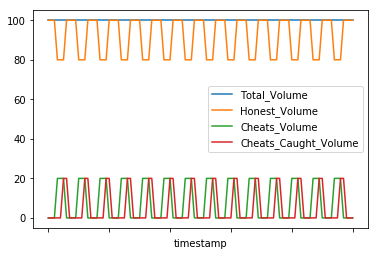

In [3]:
%matplotlib inline
import pandas as pd
from tabulate import tabulate
result = pd.DataFrame(run_raw_result)
result.plot('timestamp', 
            ['Total_Volume',
             'Honest_Volume',
             'Cheats_Volume',
             'Cheats_Caught_Volume'])

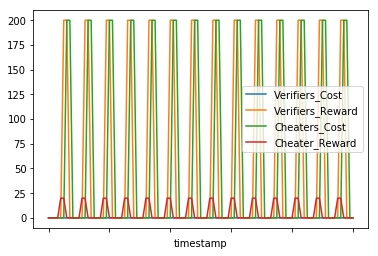

In [4]:
result.plot('timestamp', ['Verifiers_Cost',
             'Verifiers_Reward',
             'Cheaters_Cost',
             'Cheater_Reward'])

In [5]:
result.head(20)

,Cheater_Reward,Cheaters_Cost,Cheaters_On,Cheats_Caught_Volume,Cheats_Volume,Honest_Volume,Total_Volume,Verifiers_Cost,Verifiers_On,Verifiers_Reward,mech_step,run,time_step,timestamp
0,0.0,0.0,False,0.0,0.0,100.0,100,0.0,True,0.0,0,1,0,2018-01-01 00:00:00
1,0.0,0.0,0,0.0,0.0,100.0,100,0.1,0,0.0,1,1,1,2018-01-01 00:00:01
2,0.0,0.0,1,0.0,0.0,100.0,100,0.0,0,0.0,1,1,2,2018-01-01 00:00:02
3,0.0,0.0,1,0.0,20.0,80.0,100,0.0,0,0.0,1,1,3,2018-01-01 00:00:03
4,20.0,0.0,1,0.0,20.0,80.0,100,0.0,1,0.0,1,1,4,2018-01-01 00:00:04
5,20.0,0.0,0,20.0,20.0,80.0,100,0.1,1,200.0,1,1,5,2018-01-01 00:00:05
6,0.0,200.0,0,20.0,0.0,100.0,100,0.1,1,200.0,1,1,6,2018-01-01 00:00:06
7,0.0,200.0,0,0.0,0.0,100.0,100,0.1,1,0.0,1,1,7,2018-01-01 00:00:07
8,0.0,0.0,0,0.0,0.0,100.0,100,0.1,0,0.0,1,1,8,2018-01-01 00:00:08
9,0.0,0.0,1,0.0,0.0,100.0,100,0.0,0,0.0,1,1,9,2018-01-01 00:00:09
